In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
os.chdir(module_path)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import train as TR
from features import utils
from features import feature_combine, feature_clean
from features import data_clean
from evaluator import Evaluator
import gc

/home/peter/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [132]:
import config
config_file = 'test_config'
config_dict = getattr(config, config_file)
feature_list = config_dict['feature_list']
prop = utils.load_properties_data()

# Restoring the missing geo data from

https://www.kaggle.com/auroralht/restoring-the-missing-geo-data

In [106]:
prop.columns.tolist()

['parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'firep

Those columns contain Geographic Information :

|| latitude longitude

|| propertycountylandusecode propertylandusetypeid propertyzoningdesc

|| regionidcity regionidcounty regionidneighborhood regionidzip

|| censustractandblock rawcensustractandblock

In [133]:
geocolumns = [  'latitude', 'longitude'
                            ,'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc'
                            ,'regionidcity','regionidcounty', 'regionidneighborhood', 'regionidzip'
                            ,'censustractandblock', 'rawcensustractandblock']

In [134]:
geoprop = prop[geocolumns]
del prop; gc.collect()

103

In [109]:
geoprop.columns.tolist()

['latitude',
 'longitude',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'censustractandblock',
 'rawcensustractandblock']

Find out the most completed column which could be use as a reference to impute the missing value

latitude                       11437
longitude                      11437
propertycountylandusecode      12277
propertylandusetypeid          11437
propertyzoningdesc           1006588
regionidcity                   62387
regionidcounty                 11437
regionidneighborhood         1810626
regionidzip                    13765
censustractandblock            75126
rawcensustractandblock         11437
dtype: int64

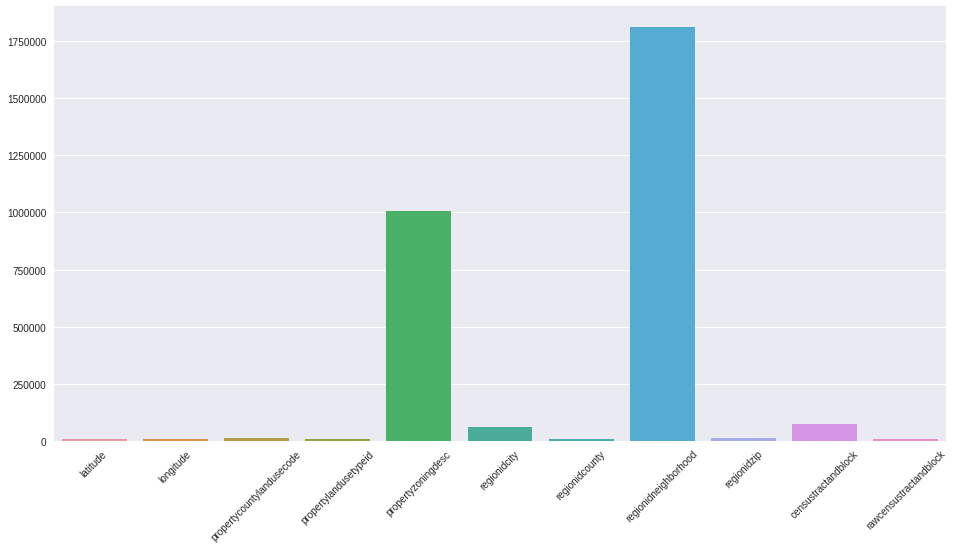

In [20]:
missingcount = geoprop.isnull().sum(axis=0)
plt.figure( figsize = (16,8) )
plot= sns.barplot( x = geocolumns,y = missingcount.values )
plt.setp( plot.get_xticklabels(), rotation = 45 )
missingcount

In [135]:
geoprop.dropna( axis = 0, subset = [ 'latitude', 'longitude' ], inplace = True )
geoprop.loc[:,'latitude'] = geoprop.loc[:,'latitude']/1e6
geoprop.loc[:,'longitude'] = geoprop.loc[:,'longitude']/1e6

    conda config --add channels conda-forge
    conda install basemap
    conda install -c conda-forge basemap-data-hires

need basemap 1.0.8

In [55]:
from mpl_toolkits.basemap import Basemap, cm

In [73]:
def create_basemap( llcrnrlat=20,urcrnrlat=50,llcrnrlon=-130,urcrnrlon=-60, figsize=(16,9) ):
    fig=plt.figure( figsize = figsize )
    Bm = Basemap( projection='merc', 
                llcrnrlat=llcrnrlat,urcrnrlat=urcrnrlat,
                llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,
                lat_ts=20,resolution='i' )
    # draw coastlines, state and country boundaries, edge of map.
    Bm.drawcoastlines(); 
    Bm.drawstates();
    Bm.drawcountries() 
    return Bm, fig    

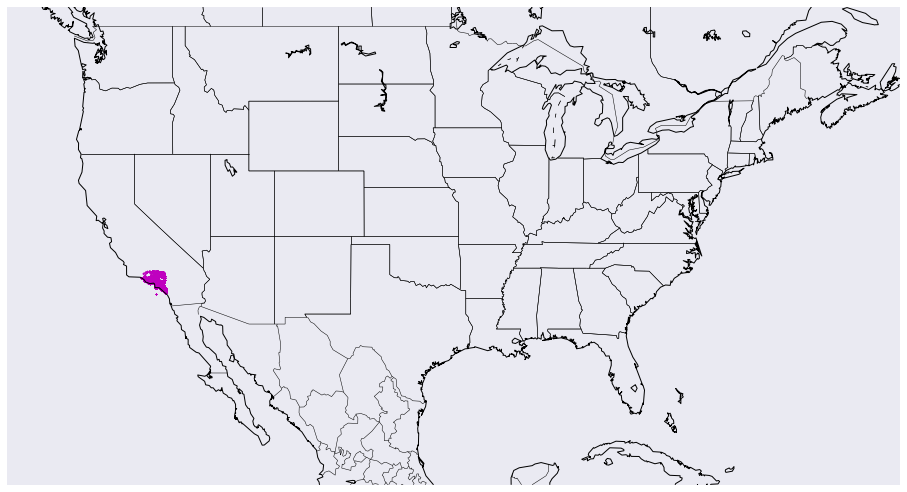

In [61]:
Bm, fig = create_basemap()
x,y = Bm( geoprop['longitude'].values, geoprop['latitude'].values)                           
Bm.scatter( x, y, marker = 'D',color = 'm', s = 1 )
plt.show()

In [33]:
maxlat = (geoprop['latitude']).max()
maxlon = (geoprop['longitude']).max()
minlat = (geoprop['latitude']).min()
minlon = (geoprop['longitude']).min()
print('maxlat {} minlat {} maxlon {} minlon {}'.format(maxlat, minlat, maxlon, minlon))

CAparms = { 'llcrnrlat' : minlat,
                     'urcrnrlat' : maxlat+0.2,
                     'llcrnrlon' : maxlon-2.5,
                     'urcrnrlon' :minlon+2.5 }

maxlat 34.819648 minlat 33.324388 maxlon -117.55432 minlon -119.475776


In [147]:
def view_map( df, target,see_known=True , see_unknown = True, ignorefirst = False, highlight = False):
    Bm, fig = create_basemap( **CAparms )
    # plot the known data
    if see_known:
        notmiss_df = df.loc[ df[target].notnull() ]
        groupby = notmiss_df.groupby(target)
        groups = [ groupby.get_group(g) for g in groupby.groups ]
        groups = groups[1:] if ignorefirst else groups 
        print( 'num groups:  ', len( groups ) )
        for group in groups:
            x,y = Bm( group['longitude'].values, group['latitude'].values )  
            if highlight:
                Bm.scatter( x, y,  marker = 'D', s = 1, color = 'red' )
            else:
                Bm.scatter( x, y,  marker = 'D', s = 1 )

    # plot the missing data
    if see_unknown:
        missing_target = df[target].isnull()
        if missing_target.any():
            print( '{} missing value at column: {}'.format( missing_target.sum(), target ) )
            missing = df.loc[ missing_target, ['latitude','longitude'] ]
            x,y = Bm( missing['longitude'].values, missing['latitude'].values )  
            Bm.scatter( x, y,  marker='D',s = 3, color = 'yellow', alpha = 0.1 )
        else:
            print('zero missing value at column: ', target )
        
    Bm.drawcounties( color='b', linewidth=0.3 )
    plt.show()

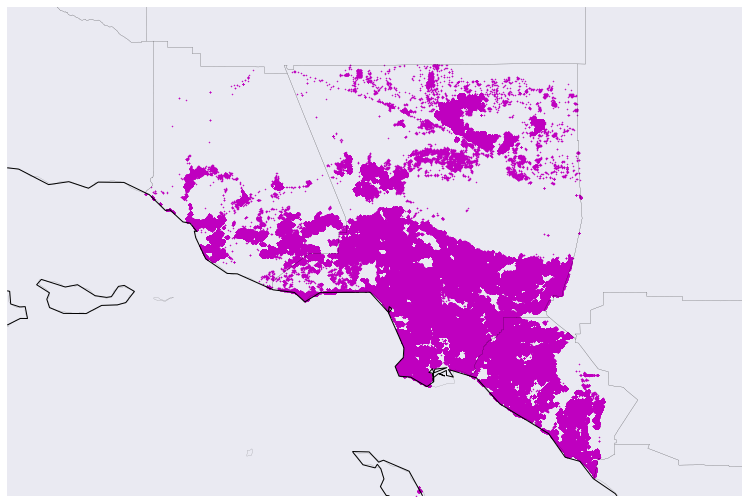

In [74]:
Bm, fig = create_basemap(**CAparms)
x,y = Bm( geoprop['longitude'].values, geoprop['latitude'].values)                           
Bm.scatter( x, y, marker = 'D',color = 'm', s = 1 )
Bm.drawcounties()
plt.show()

The yellow marker is the location of missing value

num groups:   186
50950 missing value at column: regionidcity


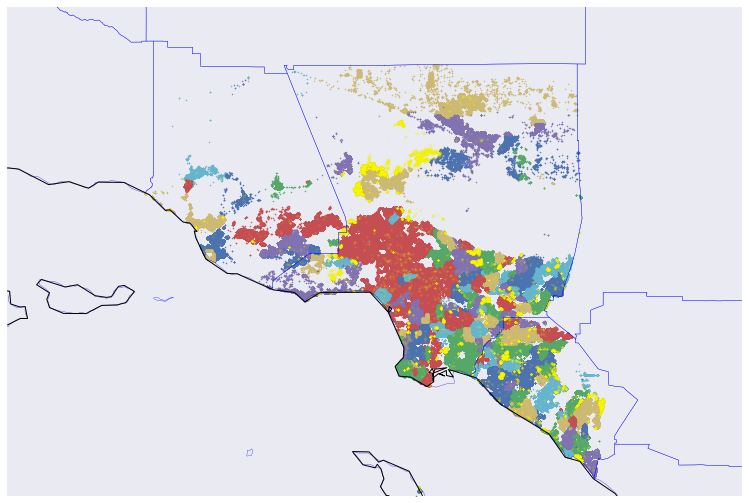

In [75]:
view_map( geoprop, 'regionidcity', ignorefirst = False )

In [5]:
from sklearn import neighbors
from sklearn.preprocessing import OneHotEncoder

def fillna_knn( df, base, target, fraction = 1, threshold = 10 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base # [regionidcity, lat, lon]
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print( 'fitting' )
    n_neighbors = 5
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    print( 'the shape of active features: ' ,enc.active_features_.shape )
    
    print( 'perdicting' )
    Z = clf.predict(df.loc[ miss, base  ])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        print( 'writing result to df_new' )
        df_new = df.copy()
        df_new.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        print( 'num of unperdictable data: ', numunperdicted )
        return df_new
    else:
        print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )

In [152]:
df_new=fillna_knn( df = geoprop,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcity', fraction = 0.15 )

fitting
the shape of active features:  (185,)
perdicting
writing result to df_new
num of unperdictable data:  72.0


num groups:   187
zero missing value at column:  regionidcity


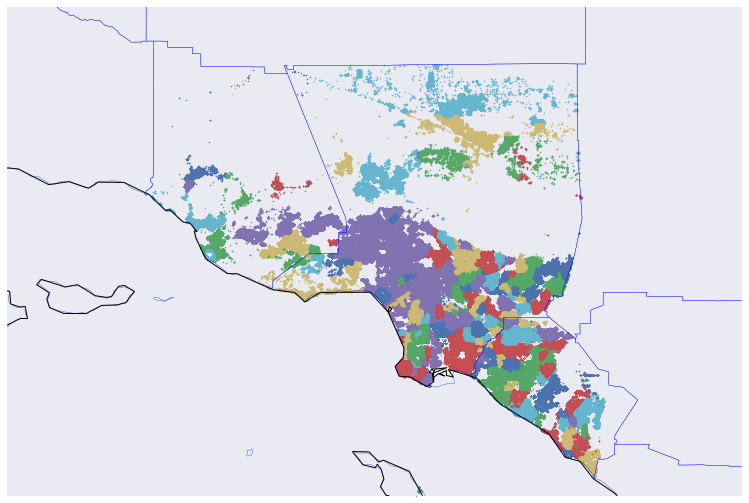

In [115]:
view_map( df_new, 'regionidcity', ignorefirst = False )

The first group (regionidcity=0) is also unpredicted

In [155]:
geoprop[geoprop['regionidcity']==0]

,latitude,longitude,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,censustractandblock,rawcensustractandblock


In [156]:
df_new[df_new['regionidcity']==0]

,latitude,longitude,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,censustractandblock,rawcensustractandblock
242,33.930196,-118.229416,0700,263.0,NaN,0.0,3101.0,NaN,96040.0,NaN,60375404.0
12841,33.736300,-117.992000,71,263.0,NaN,0.0,1286.0,NaN,96990.0,6.059100e+13,60590996.0
13865,33.736300,-117.992000,0,263.0,NaN,0.0,1286.0,NaN,96990.0,6.059100e+13,60590996.0
24006,33.957988,-117.913608,0100,261.0,LAC15000*,0.0,3101.0,NaN,96492.0,6.037409e+13,60374088.0
25880,33.737788,-117.992768,122,261.0,NaN,0.0,1286.0,NaN,96973.0,6.059100e+13,60590996.0
27861,33.770232,-117.830768,34,266.0,NaN,0.0,1286.0,NaN,97005.0,6.059076e+13,60590756.0
28467,33.736300,-117.992000,73,263.0,NaN,0.0,1286.0,NaN,96990.0,6.059100e+13,60590996.0
28880,33.736300,-117.992000,0,263.0,NaN,0.0,1286.0,NaN,96990.0,6.059100e+13,60590996.0
57435,33.736300,-117.992000,73,263.0,NaN,0.0,1286.0,NaN,96990.0,6.059100e+13,60590996.0
58988,33.897000,-118.375000,010C,266.0,HAM2*,0.0,3101.0,NaN,96107.0,6.037602e+13,60376024.0


In [153]:
groupscity = df_new.groupby('regionidcity')
groups =[ groupscity.get_group(x) for x in groupscity.groups ]

num groups:   1
zero missing value at column:  regionidcity


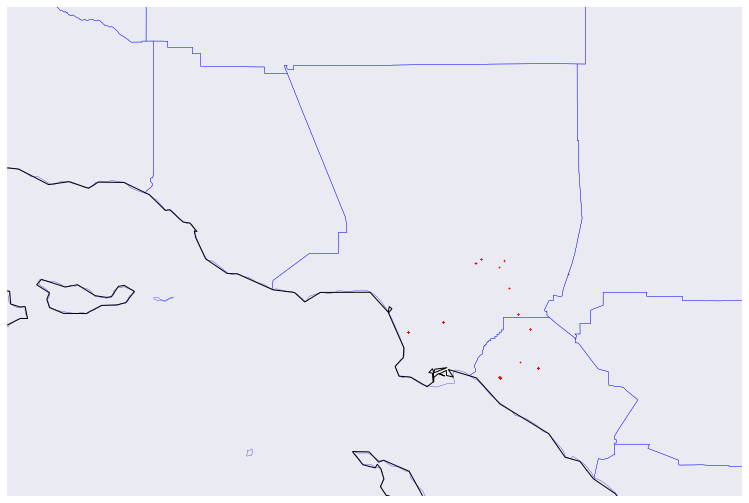

In [154]:
view_map(groups[0], 'regionidcity', highlight=True)

In [145]:
missingcount = df_new.isnull().sum(axis=0)
missingcount[missingcount>0]

propertycountylandusecode        840
propertyzoningdesc            995151
regionidneighborhood         1799189
regionidzip                     2328
censustractandblock            63689
dtype: int64

1799189 missing value at column: regionidneighborhood


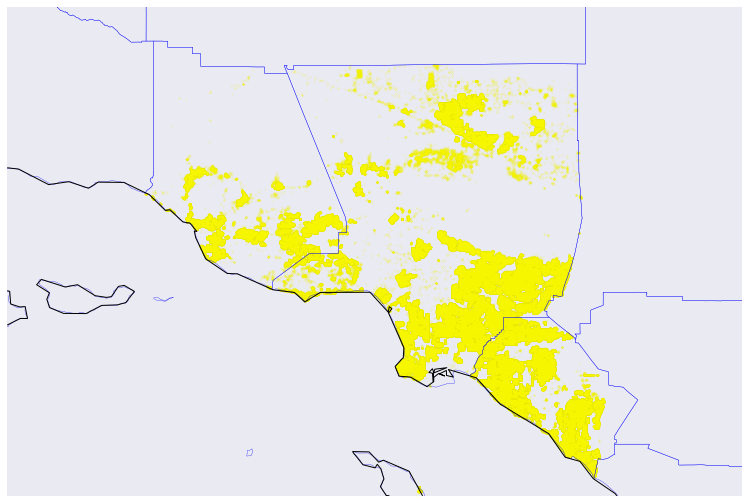

In [150]:
view_map( geoprop, 'regionidneighborhood',see_known=False, ignorefirst = False )

num groups:   528


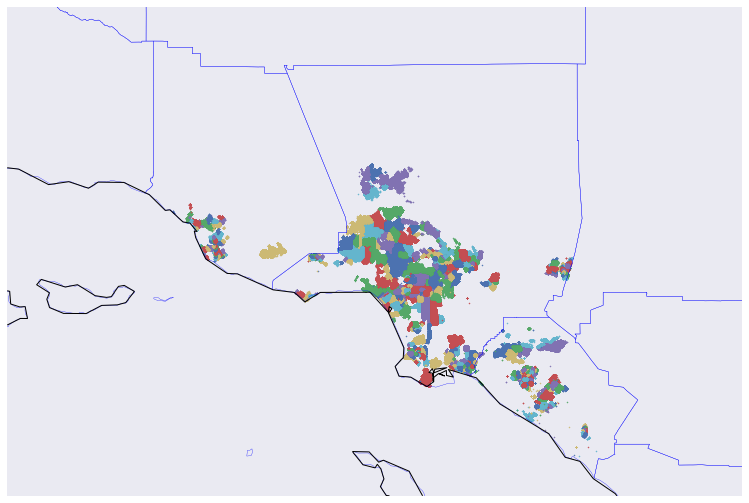

In [149]:
view_map( geoprop, 'regionidneighborhood',see_unknown=False, ignorefirst = False )

# It seems neighborhood is not a good way to crack on. Let's do regionidzip

In [157]:
df_new=fillna_knn( df = df_new,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidzip', fraction = 0.15 )

fitting
the shape of active features:  (397,)
perdicting
writing result to df_new
num of unperdictable data:  3.0


## Before

num groups:   405
2328 missing value at column: regionidzip


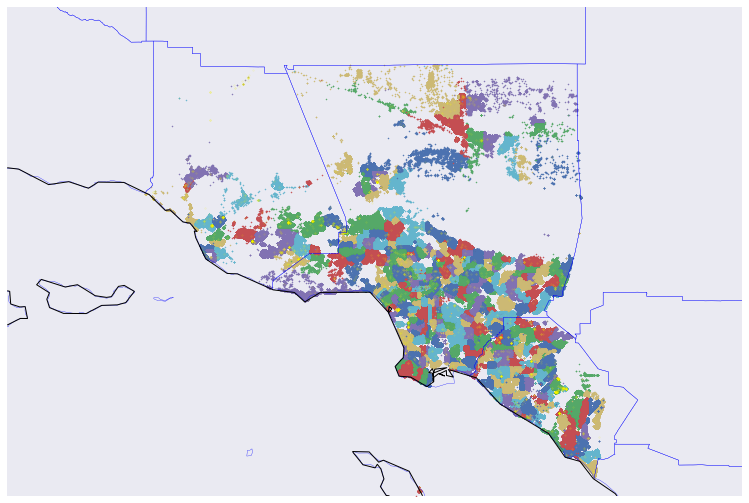

In [159]:
view_map( geoprop, 'regionidzip',see_unknown=True, ignorefirst = False )

## After

num groups:   406
zero missing value at column:  regionidzip


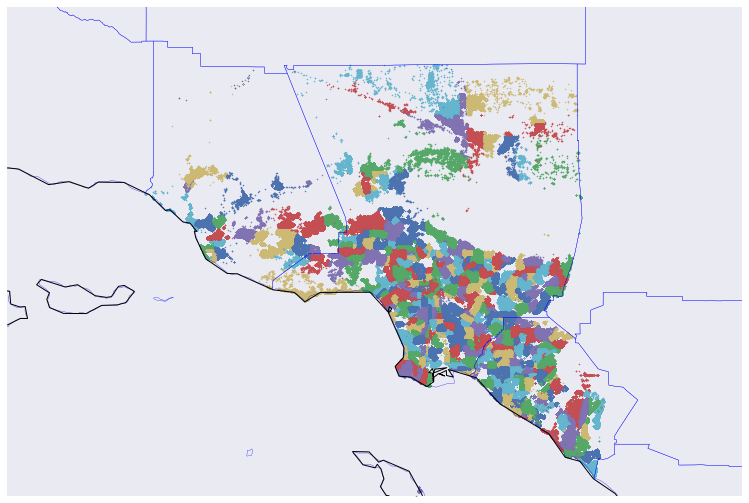

In [160]:
view_map( df_new, 'regionidzip',see_unknown=True, ignorefirst = False )

num groups:   457
63689 missing value at column: censustractandblock


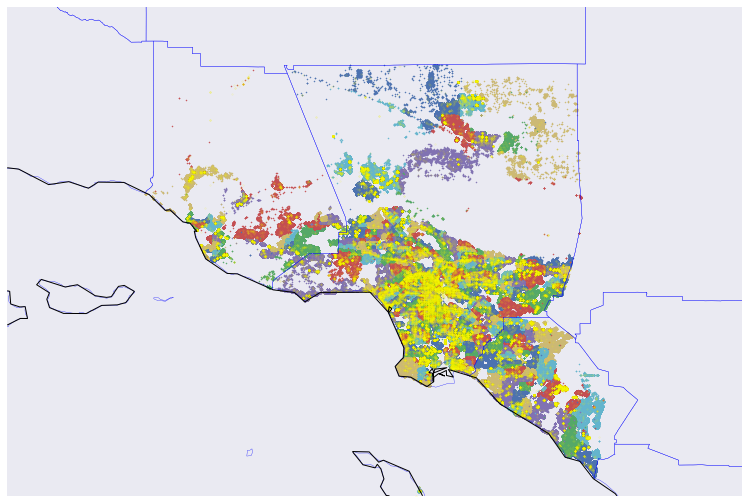

In [165]:
view_map( df_new, 'censustractandblock',see_unknown=True, ignorefirst = False )

In [164]:
df_new['censustractandblock'].value_counts()

 6.059032e+13    70434
 6.059053e+13    65051
 6.059063e+13    57502
 6.059099e+13    55686
 6.059022e+13    53413
 6.037920e+13    48233
 6.059042e+13    45876
 6.059076e+13    35386
 6.059110e+13    34951
 6.059100e+13    34487
 6.037403e+13    30656
 6.037911e+13    28589
 6.111007e+13    26391
 6.037901e+13    23057
 6.059042e+13    22560
 6.037409e+13    22003
 6.111005e+13    21960
 6.111008e+13    21690
 6.037910e+13    21561
 6.037901e+13    20602
 6.037920e+13    20476
 6.037670e+13    19899
 6.037800e+13    19485
 6.037555e+13    19159
 6.037620e+13    18681
 6.059001e+13    18462
 6.111006e+13    18151
 6.111001e+13    16077
 6.037113e+13    15870
 6.059002e+13    15609
                 ...  
 6.037227e+13      559
 6.037228e+13      557
 6.037191e+13      490
 6.037225e+13      488
 6.037233e+13      447
 6.037610e+13      414
 6.037210e+13      401
 6.037190e+13      401
 6.037224e+13      368
 6.037980e+13      326
 6.037209e+13      266
 6.037209e+13      265
 6.037226e+

In [168]:
df_new.loc[df_new['censustractandblock'] < 0, 'censustractandblock'] = np.nan

In [171]:
del geoprop; gc.collect()

61933

In [178]:
df_new.groupby('censustractandblock').count()

,latitude,longitude,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidneighborhood,regionidzip,rawcensustractandblock
censustractandblock,,,,,,,,,,
6.037101e+13,6629,6629,6629,6629,6629,6629,6629,6628,6629,6629
6.037102e+13,3467,3467,3467,3467,3467,3467,3467,3301,3467,3467
6.037103e+13,2471,2471,2471,2471,2471,2471,2471,2471,2471,2471
6.037103e+13,4703,4703,4703,4703,4703,4703,4703,4696,4703,4703
6.037104e+13,6835,6835,6835,6835,6833,6835,6835,6609,6835,6835
6.037105e+13,3957,3957,3957,3957,3957,3957,3957,3957,3957,3957
6.037105e+13,1543,1543,1543,1543,1543,1543,1543,1543,1543,1543
6.037106e+13,2204,2204,2204,2204,2204,2204,2204,2182,2204,2204
6.037106e+13,7825,7825,7825,7825,7823,7825,7825,7708,7825,7825


Memory leaking. Restarting.

In [184]:
df_new.to_pickle('geo_df.pickle')

In [29]:
df_new=pd.read_pickle('geo_df.pickle')

In [17]:
def categorise(df):
    categories = {k: v for v, k in enumerate(df.stack().unique())}
    return df.replace(categories)

In [19]:
df_census=categorise(pd.DataFrame(df_new['censustractandblock']))

In [27]:
df_new['censustractandblock'] = df_census['censustractandblock']

In [56]:
df_census = df_new[['censustractandblock', 'rawcensustractandblock']]

In [50]:
df_census.dropna()

censustractandblock       0                   NaN\n1                   N...
rawcensustractandblock    0          60378004.0\n1          60378000.0\n...
dtype: object

In [58]:
df_census['rawcensustractandblock']

0          60378004.0
1          60378000.0
2          60377032.0
3          60371412.0
4          60371232.0
5          60371252.0
6          60371436.0
7          60373108.0
8          60373100.0
9          60373204.0
10         60371112.0
11         60379200.0
12         60379200.0
13         60379204.0
14         60379104.0
15         60379108.0
16         60379108.0
17         60379008.0
18         60379004.0
19         60379104.0
20         60372348.0
21         60376008.0
22         60376012.0
23         60376016.0
24         60376020.0
25         60372760.0
26         60376204.0
27         60377028.0
28         60372756.0
29         60372724.0
              ...    
2973750    60590524.0
2973751    60590320.0
2973752    60590220.0
2973753    60590524.0
2973754    60590320.0
2973755    60590628.0
2973756    60590320.0
2973757    61110072.0
2973758    60371040.0
2973759    60374008.0
2973760    60376212.0
2973761    60371084.0
2973762    60372700.0
2973763    60590868.0
2973764   

In [57]:
df_census.applymap(str)

,censustractandblock,rawcensustractandblock
0,nan,60378004.0
1,nan,60378000.0
2,nan,60377032.0
3,nan,60371412.0
4,nan,60371232.0
5,nan,60371252.0
6,nan,60371436.0
7,nan,60373108.0
8,nan,60373100.0
9,nan,60373204.0


In [6]:
df_new=fillna_knn( df = df_new,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'censustractandblock', fraction = 0.15 )

MemoryError: 